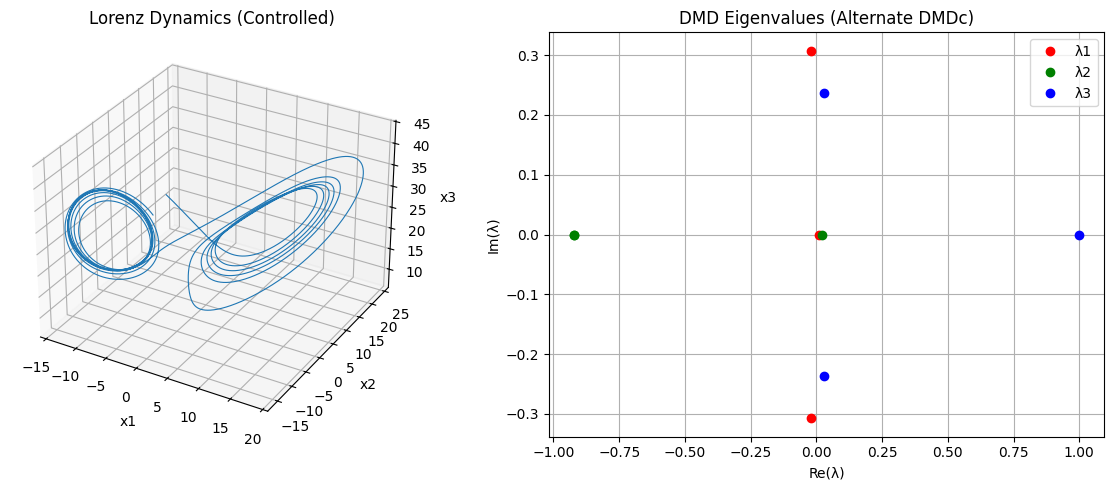

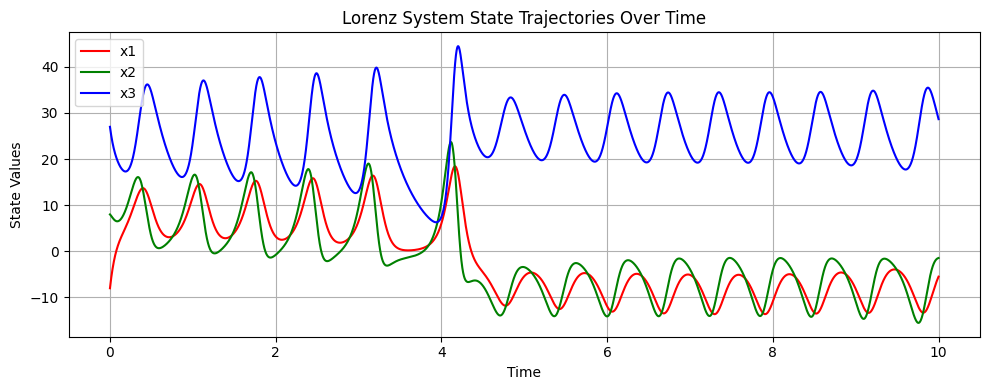

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
from numpy.linalg import svd, eig, pinv
import matplotlib.pyplot as plt

# -------------------------
# 1. Lorenz System with Control
# -------------------------
def lorenz_control(t, x, u_func):
    sigma, beta, rho = 10, 8/3, 28
    u = u_func(t)
    dx1 = sigma * (x[1] - x[0]) + u
    dx2 = x[0] * (rho - x[2]) - x[1]
    dx3 = x[0] * x[1] - beta * x[2]
    return [dx1, dx2, dx3]

def make_control(times, dt=0.001, hold_every=10, amp=20):
    raw_u = amp * np.sin(2 * np.pi * 0.1 * times)
    held_u = raw_u[::hold_every]
    def u_func(t):
        index = int(t // (dt * hold_every))
        return held_u[min(index, len(held_u)-1)]
    return u_func, held_u

# Simulation parameters
dt = 0.001
T = 10
t_eval = np.arange(0, T, dt)
u_func, control_data = make_control(t_eval, dt=dt)

# Solve the controlled Lorenz system
x0 = [-8, 8, 27]
sol = solve_ivp(lambda t, x: lorenz_control(t, x, u_func), [0, T], x0, t_eval=t_eval)

# -------------------------
# 2. Snapshot Collection
# -------------------------
step = 10  # snapshot every 10 steps
X = sol.y[:, :-1][:, ::step]
Y = sol.y[:, 1:][:, ::step]
U = np.array([u_func(t) for t in sol.t[:-1][::step]])[np.newaxis, :]
n, m = X.shape
q = U.shape[0]

# -------------------------
# 3. Alternate DMDc Implementation (Algorithm 2)
# -------------------------
Omega = np.vstack((X, U))
Omega_pinv = pinv(Omega)

Omega1 = Omega_pinv[:, :n]
Omega2 = Omega_pinv[:, n:]

A_hat = Y @ Omega1
B_hat = Y @ Omega2

# Reduced model via truncated SVD of Omega1
U_check, S_check, Vh_check = svd(Omega1, full_matrices=False)
r = min(3, np.sum(S_check > 1e-10))  # truncate small singular values
U_r = U_check[:, :r]
S_r = np.diag(S_check[:r])
V_r = Vh_check[:r, :]

# Reduced operators
A_tilde = V_r @ (Y @ U_r @ S_r)
B_tilde = V_r @ (Y @ Omega2)

# Eigendecomposition
W, Lambda = eig(A_tilde)

# -------------------------
# 4. Plot Results
# -------------------------

# --- (A) 3D Lorenz Trajectory Plot ---
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(sol.y[0], sol.y[1], sol.y[2], linewidth=0.8)
ax1.set_title("Lorenz Dynamics (Controlled)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_zlabel("x3")

# --- (B) DMD Eigenvalues Plot ---
ax2 = fig.add_subplot(122)
colors = ['r', 'g', 'b', 'm', 'c', 'y']
for i in range(len(Lambda)):
    ax2.plot(Lambda.real[i], Lambda.imag[i], 'o', label=f"λ{i+1}", color=colors[i % len(colors)])
ax2.set_xlabel("Re(λ)")
ax2.set_ylabel("Im(λ)")
ax2.set_title("DMD Eigenvalues (Alternate DMDc)")
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# --- (C) 1D Time Series Plot of x1, x2, x3 ---
plt.figure(figsize=(10, 4))
plt.plot(t_eval, sol.y[0], label="x1", color='r')
plt.plot(t_eval, sol.y[1], label="x2", color='g')
plt.plot(t_eval, sol.y[2], label="x3", color='b')
plt.title("Lorenz System State Trajectories Over Time")
plt.xlabel("Time")
plt.ylabel("State Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
